# Assignment 3

In [1]:
import os
import glob

import pickle

import numpy as np
import pandas as pd
import random
from PIL import Image

import matplotlib.pyplot as plt 

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn import svm
from sklearn.cluster import KMeans

!pip uninstall opencv
!pip install -U opencv-contrib-python
import cv2 as cv

     |████████████████████████████████| 66.5 MB 121 kB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print(cv.__version__)

4.5.4


# get bags of SIFT

In [11]:
def save(mat, title):
  write_file = open(title, "wb")
  pickle.dump(mat, write_file)
  write_file.close()

def load(filename):
  with open(filename,'rb') as file:
    mat = pickle.load(file)
    print('size of vocab: ',len(mat))
  return mat


In [216]:
def const_hist(des,centers):
  hist = np.zeros((len(centers)))
  for d in des:
    dist =  100000000
    loc = 0
    for i in range(len(centers)):
      eucDist = np.sqrt(np.sum((centers[i]-d)**2))
      if eucDist < dist:
        dist = eucDist
        loc = i 
    hist[loc]+=1

  return hist 

In [217]:
# Starter code tranlated from James Hays's code for Computer Vision Fall 2019

#This feature representation is described in the handout, lecture
#materials, and Szeliski chapter 14.

def get_bags_of_sifts(image_paths):
  vocab = load('/content/vocab.pkl')
  r,c = vocab.shape
  img_features = np.zeros((len(image_paths),r))
  counter = 0
  sift = cv.xfeatures2d.SIFT_create(250) #specify how many maximum descriptors you want in the output 
    
  for img_p in image_paths:
    im = Image.open(img_p)
    col, row = im.size
    im.thumbnail(((col/3)*2,(row/3)*2), Image.ANTIALIAS) 
    img = np.array(im)
    kp, des = sift.detectAndCompute(img, None)
    if des is not None:
      #take a sample of the descriptors
      #samp_des = np.array(random.sample(list(des),int(np.ceil(len(des)/3))))
      samp_des = des
      #make histogram of image
      hist = const_hist(samp_des, vocab) 
      #normalize
      normalized = (hist- hist.min())/(hist.max() - hist.min())
      img_features[counter:counter+1] = normalized
      counter+=1
  
  return img_features

# image_paths is an N x 1 cell array of strings where each string is an
# image path on the file system.

# This function assumes that 'vocab.pkl' exists and contains an N x 128
# matrix 'vocab' where each row is a kmeans centroid or visual word. This
# matrix is saved to disk rather than passed in a parameter to avoid
# recomputing the vocabulary in every run.

# image_feats is an N x d matrix, where d is the dimensionality of the
# feature representation. In this case, d will equal the number of clusters
# or equivalently the number of entries in each image's histogram
# ('vocab_size') below.

# You will want to construct SIFT features here in the same way you
# did in build_vocabulary function (except for possibly changing the sampling
# rate) and then assign each local feature to its nearest cluster center
# and build a histogram indicating how many times each cluster was used.
# Don't forget to normalize the histogram, or else a larger image with more
# SIFT features will look very different from a smaller version of the same
# image.

#  SIFT_features is a 128 x N matrix of SIFT features
#   note: there are smoothing parameters you can manipulate for sift function





# Build Vocabulary 

In [142]:
# Starter code tranlated from James Hays's code for Computer Vision Fall 2019

#This function will sample SIFT descriptors from the training images,
#cluster them with kmeans, and then return the cluster centers.

def build_vocabulary(image_paths, vocab_size):
  all_desc = []
  sift = cv.xfeatures2d.SIFT_create(50) #specify how many maximum descriptors you want in the output 
  none_img = 0
    
  for img_path in image_paths:
    im = Image.open(img_path)
    col, row = im.size
    im.thumbnail((np.rint((col/3)*2),np.rint((row/3)*2)), Image.ANTIALIAS) 
    img = np.array(im)
    kp, des = sift.detectAndCompute(img, None)
    if des is None:
      print(img_path, '  has None descriptor')
      none_img+=1
    else:
      #take a sample of the descriptors
      #samp_des = np.array(random.sample(list(des),int(np.ceil(len(des)/4))))
      samp_des = des
      all_desc.extend(samp_des)

  kmeans = KMeans(n_clusters = vocab_size)
  kmeans.fit(np.array(all_desc))
  vocab = kmeans.cluster_centers_

  #save file using  pickle
  save(vocab,'vocab.pkl')
  print('vocabilary succefully build /n',none_img,' image with none descriptors  discovered')
  return vocab
# The inputs are 'image_paths', a N x 1 cell array of image paths, and
# 'vocab_size' the size of the vocabulary.

# The output 'vocab' should be vocab_size x 128. Each row is a cluster
# centroid / visual word.


# Load images from the training set. To save computation time, you don't
# necessarily need to sample from all images, although it would be better
# to do so. You can randomly sample the descriptors from each image to save
# memory and speed up the clustering. 

# For each loaded image, get some SIFT features. You don't have to get as
# many SIFT features as you will in get_bags_of_sift, because you're only
# trying to get a representative sample here.

# Once you have tens of thousands of SIFT features from many training
# images, cluster them with kmeans. The resulting centroids are now your
# visual word vocabulary.



# get image paths

# Nearest Neighbor Classifier

In [21]:
# Starter code tranlated from James Hays's code for Computer Vision Fall 2019

#This function will predict the category for every test image by finding
#the training image with most similar features. Instead of 1 nearest
#neighbor, you can vote based on k nearest neighbors which will increase
#performance (although you need to pick a reasonable value for k).

def nearest_neighbor_classify(train_image_feats, train_labels, test_image_feats):
  pred_cat = []
  k = 15
  for te_img_feat in test_image_feats:
    dist_vec = []
    #1: calculate distance between train and test point
    for tr_img_feat in train_image_feats:
      dist = np.sqrt(np.sum((te_img_feat - tr_img_feat)**2))#.........euclidean
      #dist = np.sum(tr_img_feat - te_img_feat)             #manhatten
      dist_vec.append(dist)
    
    #2:sort the dict_vec to get k nearest neighbours
    sorted_list = np.argsort(dist_vec)
    near_nei = sorted_list[:k]

    #3:majority voting
    classes = {}
    for n in near_nei:
      if train_labels[n] in list(classes):
        classes[train_labels[n]]+=1
      else:
        classes[train_labels[n]] = 1
    
    max = 0
    for key in list(classes):
      if max < classes[key]:
        max = classes[key]
        label = key

    #add label into the predicted categories
    pred_cat.append(label)
    
  return np.array(pred_cat)
# image_feats is an N x d matrix, where d is the dimensionality of the
#  feature representation.
# train_labels is an N x 1 cell array, where each entry is a string
#  indicating the ground truth category for each training image.
# test_image_feats is an M x d matrix, where d is the dimensionality of the
#  feature representation. You can assume M = N unless you've modified the
#  starter code.
# predicted_categories is an M x 1 cell array, where each entry is a string
#  indicating the predicted category for each test image.

# SVM Classifier

In [36]:
# Starter code tranlated from James Hays's code for Computer Vision Fall 2019

#This function will train a linear SVM for every category (i.e. one vs all)
#and then use the learned linear classifiers to predict the category of
#every test image. Every test feature will be evaluated with all 15 SVMs
#and the most confident SVM will "win". Confidence, or distance from the
#margin, is W*X + B where '*' is the inner product or dot product and W and
#B are the learned hyperplane parameters.

def svm_classify(train_image_feats, train_labels, test_image_feats):
    
    #make an SVM classifier
    clf = svm.LinearSVC()
    #clf = svm.LinearSVC(random_state=2, tol=1e-07)

    #fit on the training data
    #you need to put your own array names here
    clf.fit(train_image_feats, list(train_labels))
    pred_cat = clf.predict(test_image_feats)
    return np.array(pred_cat)
# image_feats is an N x d matrix, where d is the dimensionality of the
#  feature representation.
# train_labels is an N x 1 cell array, where each entry is a string
#  indicating the ground truth category for each training image.
# test_image_feats is an M x d matrix, where d is the dimensionality of the
#  feature representation. You can assume M = N unless you've modified the
#  starter code.
# predicted_categories is an M x 1 cell array, where each entry is a string
#  indicating the predicted category for each test image.


# Display results

In [5]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots(figsize = (6, 6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

def perf_measure(y_actual, y_hat):
    TP, FP, TN, FN = 0, 0, 0, 0
    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
            TP += 1
        elif y_hat[i]==1 and y_actual[i]!=y_hat[i]:
            FP += 1
        elif y_actual[i]==y_hat[i]==0:
            TN += 1
        elif y_hat[i]==0 and y_actual[i]!=y_hat[i]:
            FN += 1

    return [TP, FP, TN, FN]


def display_results(test_label, categories, predicted_categories, title):
    df = pd.DataFrame(columns= ['Category']+list(categories))
    
    cols = ['Category']+['TP', 'FP', 'TN', 'FN']
    df = pd.DataFrame(columns= cols)
    
    for el in categories:
      temp_y_test = (test_label == el).astype(int)
      temp_preds = (predicted_categories == el).astype(int)
      row = [el]+ perf_measure(temp_y_test, temp_preds)
      df = df.append(pd.Series(row, index=cols), ignore_index=True)
    print(df, '\n\n')

    temp_test_labels = test_label

    for i in range(len(categories)):
        temp_test_labels[temp_test_labels==categories[i]] = i
        predicted_categories[predicted_categories==categories[i]] = i
    temp_test_labels, predicted_categories = temp_test_labels.astype(int), predicted_categories.astype(int)

    class_names=np.array(categories)
    plot_confusion_matrix(temp_test_labels, predicted_categories, classes=class_names)
    fig = plt.gcf()
    fig.savefig(title)
    fig.show()
    
    acc = accuracy_score(y_pred=predicted_categories, y_true=temp_test_labels) #you need to put your own array names here
    print('Accuracy: ', acc)
    
    return

In [48]:
def visualizeCats(test_ids, preds, paths):
  TP_dic = {}
  FN_dic = {}
  FP_dic = {}
  for i in range(len(preds)):
    #True Positive cases
    if test_ids[i] == preds[i]:
      #if test_ids[i] not in list(TP_dic):
      TP_dic[test_ids[i]] = paths[i]
    #False Negative cases
    elif test_ids[i] != preds[i]:
      if test_ids[i] not in list(FN_dic):
        FN_dic[test_ids[i]] = [paths[i],preds[i]]
      else:
        if preds[i] not in list(FP_dic):
          FP_dic[preds[i]] = [paths[i],test_ids[i]]
  print('True positive dictionary: ', TP_dic,
        '\n False Positive dictionary: ', FP_dic,
        '\nFalse Negative dictionary: ', FN_dic)      

In [8]:
# Starter code tranlated from James Hays's code for Computer Vision Fall 2019

#This function returns numpy arrays containing the file path for each train
#and test image, with their labels 

def get_image_paths(data_path, categories):
    train_image_paths, train_labels = [], []
    for cat in categories:
        imgs = glob.glob(data_path+'train/'+cat+'/*.*')
        train_image_paths = train_image_paths + imgs
        train_labels = train_labels + [cat]*len(imgs)

    test_image_paths, test_labels = [], []
    for cat in os.listdir(data_path+'test/'):
        imgs = glob.glob(data_path+'test/'+cat+'/*.*')
        test_image_paths = test_image_paths + imgs
        test_labels = test_labels + [cat]*len(imgs)

    return np.array(train_image_paths), np.array(test_image_paths), np.array(train_labels), np.array(test_labels)  

In [9]:
#This is the list of categories / directories to use. The categories are
#somewhat sorted by similarity so that the confusion matrix looks more
#structured (indoor and then urban and then rural).
data_path = '/content/drive/MyDrive/assignment3.zip (Unzipped Files)/data/'

categories = np.array(['Kitchen', 'Store', 'Bedroom', 'LivingRoom', 'Office',
              'Industrial', 'Suburb', 'InsideCity', 'TallBuilding', 'Street',
              'Highway', 'OpenCountry', 'Coast', 'Mountain', 'Forest'])
   
# #This list of shortened category names is used later for visualization.
# abbr_categories = np.array(['Kit', 'Sto', 'Bed', 'Liv', 'Off', 'Ind', 'Sub',
#                    'Cty', 'Bld', 'St', 'HW', 'OC', 'Cst', 'Mnt', 'For'])
    

#This function returns cell arrays containing the file path for each train
#and test image, as well as cell arrays with the label of each train and
#test image. By default all four of these arrays will be 1500x1 where each
#entry is a char array (or string).
print('Getting paths and labels for all train and test data\n')
train_image_paths, test_image_paths, train_labels, test_labels = get_image_paths(data_path, categories)


#   train_image_paths  1500x1   cell      
#   test_image_paths   705x1    cell           
#   train_labels       1500x1   cell         
#   test_labels        705x1    cell       

Getting paths and labels for all train and test data



In [266]:
# Starter code tranlated from James Hays's code for Computer Vision Fall 2019

# All of your code will be in "Step 1" and "Step 2", although you can
# modify other parameters in the starter code.

## Step 0: Set up parameters, category list, and image paths.

#For this Assignment, you will need to report performance for three
#combinations of features / classifiers. It is suggested you code them in
#this order, as well:
# 1) Tiny image features and nearest neighbor classifier
# 2) Bag of sift features and nearest neighbor classifier
# 3) Bag of sift features and linear SVM classifier

#The starter code is initialized to 'placeholder' just so that the starter
#code does not crash when run unmodified and you can get a preview of how
#results are presented.

# FEATURE = 'tiny image'
FEATURE = 'bag of sift'
#FEATURE = 'placeholder'

## Step 1: Represent each image with the appropriate feature
# Each function to construct features should return an N x d matrix, where
# N is the number of paths passed to the function and d is the 
# dimensionality of each image representation. See the starter code for
# each function for more details.

print("Using",FEATURE, "representation for images\n")


if(FEATURE == 'bag of sift'):
    # Code build_vocabulary function 1st
    if(os.path.isfile('/content/vocab.pkl') == False):
        print('No existing visual word vocabulary found. Computing one from training images\n')
        vocab_size = 50 #Larger values will work better (to a point) but be slower to compute
        vocab = build_vocabulary(train_image_paths, vocab_size)
     # Code get_bags_of_sifts function
    train_image_feats = get_bags_of_sifts(train_image_paths)
    test_image_feats  = get_bags_of_sifts(test_image_paths)
        
elif(FEATURE == 'placeholder'):
    train_image_feats = []
    test_image_feats = []
        
else:
    print('Unknown feature type')


# You should avoid recomputing the features while debugging the classifiers
# so you need to 'save' and 'load' the features using pickle library



Using bag of sift representation for images

No existing visual word vocabulary found. Computing one from training images

/content/drive/MyDrive/assignment3.zip (Unzipped Files)/data/train/Coast/image_0258.jpg   has None descriptor
/content/drive/MyDrive/assignment3.zip (Unzipped Files)/data/train/Coast/image_0283.jpg   has None descriptor
vocabilary succefully build /n 2  image with none descriptors  discovered
size of vocab:  50
size of vocab:  50


In [219]:
train_image_feats.shape, test_image_feats.shape

((1500, 200), (705, 200))

In [220]:
#the new built features
save(train_image_feats, 'train_features200.pkl')
save(test_image_feats, 'test_features200.pkl')

In [12]:
#reload features
train_image_feats = load('train_features200.pkl')
test_image_feats = load('test_features200.pkl')

size of vocab:  1500
size of vocab:  705


In [37]:
## Step 2: Classify each test image by training and using the appropriate classifier
#  to classify test features should return an N x 1 cell array,
# where N is the number of test cases and each entry is a string indicating
# the predicted category for each test image. Each entry in
# 'predicted_categories' must be one of the 15 strings in 'categories',
# 'train_labels', and 'test_labels'. See the starter code for each function
# for more details.


def N_Neigbhour():
  print('Using nearest neighbor classifier to predict test set categories\n')
  predicted_categories = nearest_neighbor_classify(train_image_feats, train_labels, test_image_feats)
  return predicted_categories
    
def Lin_SVM():
  print('Using support vector machine classifier to predict test set categories\n')
  predicted_categories = svm_classify(train_image_feats, train_labels, test_image_feats)
  return predicted_categories

def placeholder():
  print('Using placeholder to predict test set categories\n')
  predicted_categories = np.random.permutation(test_labels)
  return predicted_categories


Using placeholder to predict test set categories

        Category   TP   FP   TN   FN
0        Kitchen    0    0  705    0
1          Store    0    0  705    0
2        Bedroom   22   94  495   94
3     LivingRoom    0    0  705    0
4         Office    0    0  705    0
5     Industrial    0    0  705    0
6         Suburb    0    0  705    0
7     InsideCity    0    0  705    0
8   TallBuilding    0    0  705    0
9         Street    0    0  705    0
10       Highway   18   83  521   83
11   OpenCountry    0    0  705    0
12         Coast  101  159  286  159
13      Mountain    0    0  705    0
14        Forest   82  146  331  146 


Confusion matrix, without normalization
Accuracy:  0.31631205673758866


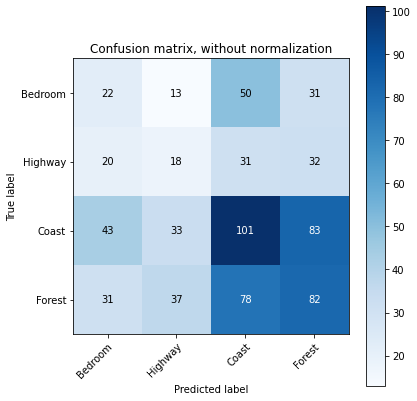

In [14]:
## Step 3: Build a confusion matrix and score the recognition system
# You do not need to code anything in this section. 

# If we wanted to evaluate our recognition method properly we would train
# and test on many random splits of the data. You are not required to do so
# for this project.

placeholder_preds = placeholder()

# This function will plot confusion matrix and accuracy of your model
display_results(np.copy(test_labels), categories, placeholder_preds,'Placeholder_matrix.jpg')

# Interpreting your performance with 100 training examples per category:
#  accuracy  =   0 -> Your code is broken (probably not the classifier's
#                     fault! A classifier would have to be amazing to
#                     perform this badly).
#  accuracy ~= .07 -> Your performance is chance. Something is broken or
#                     you ran the starter code unchanged.
#  accuracy ~= .50 -> Rough performance with bag of SIFT and nearest
#                     neighbor classifier. Can reach .60 with K-NN and
#                     different distance metrics.
#  accuracy ~= .60 -> You've gotten things roughly correct with bag of
#                     SIFT and a linear SVM classifier.
#  accuracy >= .70 -> You've also tuned your parameters well. E.g. number
#                     of clusters, SVM regularization, number of patches
#                     sampled when building vocabulary, size and step for
#                     dense SIFT features.
#  accuracy >= .80 -> You've added in spatial information somehow or you've
#                     added additional, complementary image features. This
#                     represents state of the art in Lazebnik et al 2006.
#  accuracy >= .85 -> You've done extremely well. This is the state of the
#                     art in the 2010 SUN database paper from fusing many 
#                     features. Don't trust this number unless you actually
#                     measure many random splits.
#  accuracy >= .90 -> You used modern deep features trained on much larger
#                     image databases.
#  accuracy >= .96 -> You can beat a human at this task. This isn't a
#                     realistic number. Some accuracy calculation is broken
#                     or your classifier is cheating and seeing the test
#                     labels.


Using nearest neighbor classifier to predict test set categories

        Category   TP  FP   TN   FN
0        Kitchen    0  33  672    0
1          Store    0  17  688    0
2        Bedroom   15   2  587  101
3     LivingRoom    0   9  696    0
4         Office    0   6  699    0
5     Industrial    0  25  680    0
6         Suburb    0  62  643    0
7     InsideCity    0   6  699    0
8   TallBuilding    0  59  646    0
9         Street    0   4  701    0
10       Highway   22  16  588   79
11   OpenCountry    0  32  673    0
12         Coast  153  34  411  107
13      Mountain    0  13  692    0
14        Forest  190   7  470   38 


Confusion matrix, without normalization
Accuracy:  0.5390070921985816


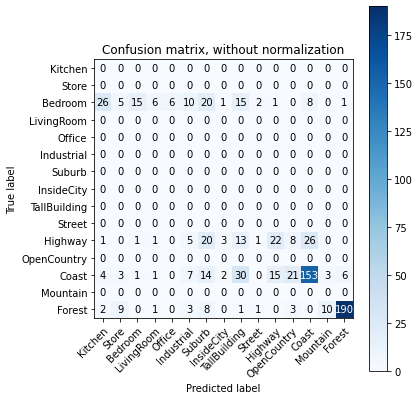

In [23]:
## Step 3: Build a confusion matrix and score the recognition system
# You do not need to code anything in this section. 

# If we wanted to evaluate our recognition method properly we would train
# and test on many random splits of the data. You are not required to do so
# for this project.

nn_preds = N_Neigbhour()

# This function will plot confusion matrix and accuracy of your model
display_results(np.copy(test_labels), categories, np.copy(nn_preds),'NN_Matrix_vocab200.jpg')

# Interpreting your performance with 100 training examples per category:
#  accuracy  =   0 -> Your code is broken (probably not the classifier's
#                     fault! A classifier would have to be amazing to
#                     perform this badly).
#  accuracy ~= .07 -> Your performance is chance. Something is broken or
#                     you ran the starter code unchanged.
#  accuracy ~= .50 -> Rough performance with bag of SIFT and nearest
#                     neighbor classifier. Can reach .60 with K-NN and
#                     different distance metrics.
#  accuracy ~= .60 -> You've gotten things roughly correct with bag of
#                     SIFT and a linear SVM classifier.
#  accuracy >= .70 -> You've also tuned your parameters well. E.g. number
#                     of clusters, SVM regularization, number of patches
#                     sampled when building vocabulary, size and step for
#                     dense SIFT features.
#  accuracy >= .80 -> You've added in spatial information somehow or you've
#                     added additional, complementary image features. This
#                     represents state of the art in Lazebnik et al 2006.
#  accuracy >= .85 -> You've done extremely well. This is the state of the
#                     art in the 2010 SUN database paper from fusing many 
#                     features. Don't trust this number unless you actually
#                     measure many random splits.
#  accuracy >= .90 -> You used modern deep features trained on much larger
#                     image databases.
#  accuracy >= .96 -> You can beat a human at this task. This isn't a
#                     realistic number. Some accuracy calculation is broken
#                     or your classifier is cheating and seeing the test
#                     labels.


In [27]:
visualizeCats(np.copy(test_labels), nn_preds, test_image_paths)

True positive dictionary:  {'Bedroom': '/content/drive/MyDrive/assignment3.zip (Unzipped Files)/data/test/Bedroom/image_0014.jpg', 'Coast': '/content/drive/MyDrive/assignment3.zip (Unzipped Files)/data/test/Coast/image_0001.jpg', 'Highway': '/content/drive/MyDrive/assignment3.zip (Unzipped Files)/data/test/Highway/image_0005.jpg', 'Forest': '/content/drive/MyDrive/assignment3.zip (Unzipped Files)/data/test/Forest/image_0001.jpg'} 
 False Positive dictionary:  {'Suburb': ['/content/drive/MyDrive/assignment3.zip (Unzipped Files)/data/test/Bedroom/image_0004.jpg', 'Bedroom'], 'Office': ['/content/drive/MyDrive/assignment3.zip (Unzipped Files)/data/test/Bedroom/image_0007.jpg', 'Bedroom'], 'Street': ['/content/drive/MyDrive/assignment3.zip (Unzipped Files)/data/test/Bedroom/image_0008.jpg', 'Bedroom'], 'Industrial': ['/content/drive/MyDrive/assignment3.zip (Unzipped Files)/data/test/Bedroom/image_0011.jpg', 'Bedroom'], 'Kitchen': ['/content/drive/MyDrive/assignment3.zip (Unzipped Files)/da

In [31]:
set(test_labels)

{'Bedroom', 'Coast', 'Forest', 'Highway'}

Using support vector machine classifier to predict test set categories

        Category   TP  FP   TN   FN
0        Kitchen    0  19  686    0
1          Store    0  27  678    0
2        Bedroom   33   4  585   83
3     LivingRoom    0  18  687    0
4         Office    0  15  690    0
5     Industrial    0  22  683    0
6         Suburb    0  25  680    0
7     InsideCity    0  13  692    0
8   TallBuilding    0  28  677    0
9         Street    0  19  686    0
10       Highway   44  33  571   57
11   OpenCountry    0  64  641    0
12         Coast  128  20  425  132
13      Mountain    0  30  675    0
14        Forest  151  12  465   77 


Confusion matrix, without normalization
Accuracy:  0.5049645390070922


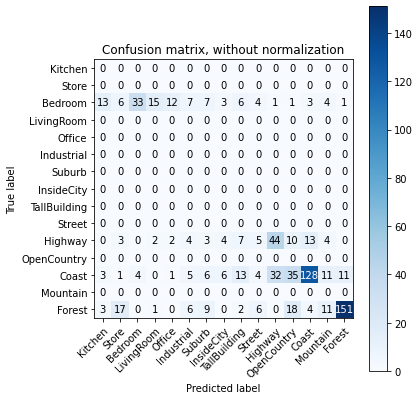

In [46]:
# Step 3: Build a confusion matrix and score the recognition system
# You do not need to code anything in this section. 

# If we wanted to evaluate our recognition method properly we would train
# and test on many random splits of the data. You are not required to do so
# for this project.

svm_preds = Lin_SVM()
# This function will plot confusion matrix and accuracy of your model
display_results(np.copy(test_labels), categories, np.copy(svm_preds),'SVM_Matrix_vocab50.jpg')

# Interpreting your performance with 100 training examples per category:
#  accuracy  =   0 -> Your code is broken (probably not the classifier's
#                     fault! A classifier would have to be amazing to
#                     perform this badly).
#  accuracy ~= .07 -> Your performance is chance. Something is broken or
#                     you ran the starter code unchanged.
#  accuracy ~= .50 -> Rough performance with bag of SIFT and nearest
#                     neighbor classifier. Can reach .60 with K-NN and
#                     different distance metrics.
#  accuracy ~= .60 -> You've gotten things roughly correct with bag of
#                     SIFT and a linear SVM classifier.
#  accuracy >= .70 -> You've also tuned your parameters well. E.g. number
#                     of clusters, SVM regularization, number of patches
#                     sampled when building vocabulary, size and step for
#                     dense SIFT features.
#  accuracy >= .80 -> You've added in spatial information somehow or you've
#                     added additional, complementary image features. This
#                     represents state of the art in Lazebnik et al 2006.
#  accuracy >= .85 -> You've done extremely well. This is the state of the
#                     art in the 2010 SUN database paper from fusing many 
#                     features. Don't trust this number unless you actually
#                     measure many random splits.
#  accuracy >= .90 -> You used modern deep features trained on much larger
#                     image databases.
#  accuracy >= .96 -> You can beat a human at this task. This isn't a
#                     realistic number. Some accuracy calculation is broken
#                     or your classifier is cheating and seeing the test
#                     labels.

In [49]:
visualizeCats(np.copy(test_labels), svm_preds, test_image_paths)

True positive dictionary:  {'Bedroom': '/content/drive/MyDrive/assignment3.zip (Unzipped Files)/data/test/Bedroom/image_0215.jpg', 'Coast': '/content/drive/MyDrive/assignment3.zip (Unzipped Files)/data/test/Coast/image_0360.jpg', 'Highway': '/content/drive/MyDrive/assignment3.zip (Unzipped Files)/data/test/Highway/image_0164.jpg', 'Forest': '/content/drive/MyDrive/assignment3.zip (Unzipped Files)/data/test/Forest/image_0328.jpg'} 
 False Positive dictionary:  {'Mountain': ['/content/drive/MyDrive/assignment3.zip (Unzipped Files)/data/test/Bedroom/image_0004.jpg', 'Bedroom'], 'InsideCity': ['/content/drive/MyDrive/assignment3.zip (Unzipped Files)/data/test/Bedroom/image_0006.jpg', 'Bedroom'], 'Office': ['/content/drive/MyDrive/assignment3.zip (Unzipped Files)/data/test/Bedroom/image_0007.jpg', 'Bedroom'], 'Store': ['/content/drive/MyDrive/assignment3.zip (Unzipped Files)/data/test/Bedroom/image_0008.jpg', 'Bedroom'], 'LivingRoom': ['/content/drive/MyDrive/assignment3.zip (Unzipped Files